In [1]:
import pystac
import pystac_client
import stackstac
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import hvplot.xarray
from dask.distributed import Client
import rioxarray
import os
import matplotlib.pyplot as plt
import ulmo
from datetime import datetime
import xarray as xr
import rioxarray as rxr
import warnings

In [2]:
# MODIFY PARAMETERS

#-------------------------------------------------------------------------
# comment ONE of these out at a time
#relative_orbit_number = 137 # change to get any particular relative orbit
#orbit_direction = 'ascending' # 'ascending', descending', 'all'
orbit_direction = 'all'
#-------------------------------------------------------------------------
# define time slice
today = datetime.today().strftime('%Y-%m-%d')
#time_slice = slice('2019-10-01','2020-09-30') # All of 2020 water year
time_slice = slice('2015-01-01',today) # All of 2020

#time_slice = slice('2017-01-01',today)
#-------------------------------------------------------------------------
polarization ='gamma0_vv'
#-------------------------------------------------------------------------
bounding_box_gf = gpd.read_file('shapefiles/mt_rainier.geojson')
#-------------------------------------------------------------------------
rainier_glaciers = gpd.read_file('shapefiles/rainier_glaciers.geojson')
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
cloud_cover_threshold = 20
#resample_freq_s1 = "W" # https://towardsdatascience.com/resample-function-of-pandas-79b17ec82a78
resample_freq_s2 = "2W"
#resample_freq = "MS"
shapefile_clip = True

In [3]:
#plt.style.use('seaborn-poster')


In [4]:
if 'relative_orbit_number' in locals():
    by_orbit = True
else: 
    by_orbit = False

In [5]:
# GDAL environment variables for better performance
os.environ['AWS_REGION']='us-west-2'
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR' 
os.environ['AWS_NO_SIGN_REQUEST']='YES' 

In [6]:
# Paste /proxy/localhost:8787 for cluster diagnostics
client = Client(local_directory='/tmp', processes=False)
client

<Client: 'inproc://172.25.45.79/532347/1' processes=1 threads=32, memory=125.71 GiB>

In [7]:
xr.set_options(keep_attrs=True)

In [8]:
# Load STAC ItemCollection
stac_items = pystac.ItemCollection.from_file('mycollection.json')
items = [item.to_dict(transform_hrefs=False) for item in stac_items]

stack = stackstac.stack(items,
                        dtype='float32')
stack

<xarray.DataArray 'stackstac-57e45068a5f86ce136d2cc50a7e61c31' (time: 382, band: 3, y: 5490, x: 5490)>
dask.array<fetch_raster_window, shape=(382, 3, 5490, 5490), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time                         (time) datetime64[ns] 2017-01-01T02:09:52 .....
    id                           (time) <U22 'S1A_20170101_10TES_ASC' ... 'S1...
  * band                         (band) <U9 'gamma0_vv' 'gamma0_vh' 'incidence'
  * x                            (x) float64 5e+05 5e+05 ... 6.097e+05 6.098e+05
  * y                            (y) float64 5.2e+06 5.2e+06 ... 5.09e+06
    sar:looks_equivalent_number  float64 4.3
    sar:resolution_range         float64 20.3
    proj:epsg                    int64 32610
    mgrs:grid_square             <U2 'ES'
    sar:frequency_band           <U1 'C'
    sentinel:mgrs                <U5 '10TES'
    platform                     (time) <U11 'sentinel-1a' ... 'sentinel-1b'
    sar:pixel_spacing_range      int64 10
    sar:looks_azimuth            int64 1
    sat:absolute_orbit           (time) int64 14632 3663 3736 ... 26566 26588
    sar:polarizations            object {'VV', 'VH'}
    mgrs:utm_zone                <U2 '10'
    sar:product_type             <U3 'RTC'
    sar:pixel_spacing_azimuth    int64 10
    sar:center_frequency         float64 5.405
    constellation                <U10 'sentinel-1'
    sar:looks_range              int64 5
    sentinel:product_ids         (time) object ['S1A_IW_GRDH_1SDV_20170101T02...
    end_datetime                 (time) <U20 '2017-01-01T02:10:07Z' ... '2021...
    start_datetime               (time) <U20 '2017-01-01T02:09:38Z' ... '2021...
    sat:orbit_state              (time) <U10 'ascending' ... 'ascending'
    proj:shape                   object {5490}
    sar:instrument_mode          <U2 'IW'
    instruments                  <U5 'c-sar'
    proj:transform               object {0.0, 1.0, -20.0, 499980.0, 5200020.0...
    mgrs:latitude_band           <U1 'T'
    sar:observation_direction    <U5 'right'
    sar:resolution_azimuth       float64 22.6
    created                      (time) <U27 '2021-11-29T19:15:01.133965Z' .....
    sat:relative_orbit           (time) int64 35 137 35 35 137 ... 64 13 115 137
    gsd                          int64 20
    title                        (band) <U21 'Gamma0 VV backscatter' ... 'Loc...
    epsg                         int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(499980.0, 5090220.0, 609780.0...
    crs:         epsg:32610
    transform:   | 20.00, 0.00, 499980.00|\n| 0.00,-20.00, 5200020.00|\n| 0.0...
    resolution:  20.0

In [9]:
# import bounding box
bounding_box_utm_gf = bounding_box_gf.to_crs(stack.crs)
xmin, ymax, xmax, ymin = bounding_box_utm_gf.bounds.values[0]

In [10]:
# filter scenes
scenes = stack.sel(band=polarization).sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice)

In [11]:
# filter by orbit direction or orbit number
if by_orbit:
    scenes = scenes.where(scenes.coords['sat:relative_orbit']==relative_orbit_number,drop=True)
    orbit_directions = scenes.coords['sat:orbit_state']
    orbit_direction = orbit_directions[0].values
elif orbit_direction == 'all':
    scenes = scenes
else:
    scenes = scenes.where(scenes.coords['sat:orbit_state']==orbit_direction,drop=True)

In [12]:
scenes

<xarray.DataArray 'stackstac-57e45068a5f86ce136d2cc50a7e61c31' (time: 382, y: 861, x: 889)>
dask.array<getitem, shape=(382, 861, 889), dtype=float32, chunksize=(1, 861, 829), chunktype=numpy.ndarray>
Coordinates:
  * time                         (time) datetime64[ns] 2017-01-01T02:09:52 .....
    id                           (time) <U22 'S1A_20170101_10TES_ASC' ... 'S1...
    band                         <U9 'gamma0_vv'
  * x                            (x) float64 5.858e+05 5.858e+05 ... 6.036e+05
  * y                            (y) float64 5.2e+06 5.2e+06 ... 5.183e+06
    sar:looks_equivalent_number  float64 4.3
    sar:resolution_range         float64 20.3
    proj:epsg                    int64 32610
    mgrs:grid_square             <U2 'ES'
    sar:frequency_band           <U1 'C'
    sentinel:mgrs                <U5 '10TES'
    platform                     (time) <U11 'sentinel-1a' ... 'sentinel-1b'
    sar:pixel_spacing_range      int64 10
    sar:looks_azimuth            int64 1
    sat:absolute_orbit           (time) int64 14632 3663 3736 ... 26566 26588
    sar:polarizations            object {'VV', 'VH'}
    mgrs:utm_zone                <U2 '10'
    sar:product_type             <U3 'RTC'
    sar:pixel_spacing_azimuth    int64 10
    sar:center_frequency         float64 5.405
    constellation                <U10 'sentinel-1'
    sar:looks_range              int64 5
    sentinel:product_ids         (time) object ['S1A_IW_GRDH_1SDV_20170101T02...
    end_datetime                 (time) <U20 '2017-01-01T02:10:07Z' ... '2021...
    start_datetime               (time) <U20 '2017-01-01T02:09:38Z' ... '2021...
    sat:orbit_state              (time) <U10 'ascending' ... 'ascending'
    proj:shape                   object {5490}
    sar:instrument_mode          <U2 'IW'
    instruments                  <U5 'c-sar'
    proj:transform               object {0.0, 1.0, -20.0, 499980.0, 5200020.0...
    mgrs:latitude_band           <U1 'T'
    sar:observation_direction    <U5 'right'
    sar:resolution_azimuth       float64 22.6
    created                      (time) <U27 '2021-11-29T19:15:01.133965Z' .....
    sat:relative_orbit           (time) int64 35 137 35 35 137 ... 64 13 115 137
    gsd                          int64 20
    title                        <U21 'Gamma0 VV backscatter'
    epsg                         int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(499980.0, 5090220.0, 609780.0...
    crs:         epsg:32610
    transform:   | 20.00, 0.00, 499980.00|\n| 0.00,-20.00, 5200020.00|\n| 0.0...
    resolution:  20.0

In [13]:
# could resample at the end in order to get more pixelwise values
if 'resample_freq_s1' in locals():
    scenes = scenes.resample(time=resample_freq_s1,restore_coord_dims=True).mean("time", keep_attrs=True)
#   resampled = lowcloud.resample(time=resample_freq).mean("time", keep_attrs=True)
else:
    scenes = scenes

In [14]:
%%time
# compute frames, drop missing data
frames_all = scenes.compute()
frames = frames_all.dropna('time',how='all')

CPU times: user 17.9 s, sys: 2.34 s, total: 20.2 s
Wall time: 13.2 s


In [15]:
mins_info = frames.argmin(dim='time',skipna=False)

In [16]:
def get_s1_rtc_stac(bbox_gdf,start_time='2015-01-01',end_time=datetime.today().strftime('%Y-%m-%d'),orbit_direction='all',polarization='gamma0_vv',collection='mycollection.json'):
    # GDAL environment variables for better performance
    os.environ['AWS_REGION']='us-west-2'
    os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR' 
    os.environ['AWS_NO_SIGN_REQUEST']='YES'
    
    # Load STAC ItemCollection
    stac_items = pystac.ItemCollection.from_file(collection)
    items = [item.to_dict(transform_hrefs=False) for item in stac_items]

    stack = stackstac.stack(items,dtype='float32')
    
    bounding_box_utm_gf = bbox_gdf.to_crs(stack.crs)
    xmin, ymax, xmax, ymin = bounding_box_utm_gf.bounds.values[0]
    time_slice = slice(start_time,end_time)
    
    scenes = stack.sel(band=polarization).sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice)
    
    if orbit_direction == 'all':
        scenes = scenes
    else:
        scenes = scenes.where(scenes.coords['sat:orbit_state']==orbit_direction,drop=True)
        
    return(scenes)

In [17]:
import s1_rtc_bs_utils

In [18]:
s1_rtc_bs_utils.get_s1_rtc_stac(bounding_box_gf)

<xarray.DataArray 'stackstac-9e5363f93c00c374482cc3a9aa1dff72' (time: 382, y: 861, x: 889)>
dask.array<getitem, shape=(382, 861, 889), dtype=float32, chunksize=(1, 861, 829), chunktype=numpy.ndarray>
Coordinates:
  * time                         (time) datetime64[ns] 2017-01-01T02:09:52 .....
    id                           (time) <U22 'S1A_20170101_10TES_ASC' ... 'S1...
    band                         <U9 'gamma0_vv'
  * x                            (x) float64 5.858e+05 5.858e+05 ... 6.036e+05
  * y                            (y) float64 5.2e+06 5.2e+06 ... 5.183e+06
    sar:looks_equivalent_number  float64 4.3
    sar:resolution_range         float64 20.3
    proj:epsg                    int64 32610
    mgrs:grid_square             <U2 'ES'
    sar:frequency_band           <U1 'C'
    sentinel:mgrs                <U5 '10TES'
    platform                     (time) <U11 'sentinel-1a' ... 'sentinel-1b'
    sar:pixel_spacing_range      int64 10
    sar:looks_azimuth            int64 1
    sat:absolute_orbit           (time) int64 14632 3663 3736 ... 26566 26588
    sar:polarizations            object {'VV', 'VH'}
    mgrs:utm_zone                <U2 '10'
    sar:product_type             <U3 'RTC'
    sar:pixel_spacing_azimuth    int64 10
    sar:center_frequency         float64 5.405
    constellation                <U10 'sentinel-1'
    sar:looks_range              int64 5
    sentinel:product_ids         (time) object ['S1A_IW_GRDH_1SDV_20170101T02...
    end_datetime                 (time) <U20 '2017-01-01T02:10:07Z' ... '2021...
    start_datetime               (time) <U20 '2017-01-01T02:09:38Z' ... '2021...
    sat:orbit_state              (time) <U10 'ascending' ... 'ascending'
    proj:shape                   object {5490}
    sar:instrument_mode          <U2 'IW'
    instruments                  <U5 'c-sar'
    proj:transform               object {0.0, 1.0, -20.0, 499980.0, 5200020.0...
    mgrs:latitude_band           <U1 'T'
    sar:observation_direction    <U5 'right'
    sar:resolution_azimuth       float64 22.6
    created                      (time) <U27 '2021-11-29T19:15:01.133965Z' .....
    sat:relative_orbit           (time) int64 35 137 35 35 137 ... 64 13 115 137
    gsd                          int64 20
    title                        <U21 'Gamma0 VV backscatter'
    epsg                         int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(499980.0, 5090220.0, 609780.0...
    crs:         epsg:32610
    transform:   | 20.00, 0.00, 499980.00|\n| 0.00,-20.00, 5200020.00|\n| 0.0...
    resolution:  20.0

In [19]:
lower_lon, upper_lat, upper_lon, lower_lat = bounding_box_gf.bounds.values[0]
lon = (lower_lon + upper_lon)/2
lat = (lower_lat + upper_lat)/2

In [20]:
URL = "https://earth-search.aws.element84.com/v0"
catalog = pystac_client.Client.open(URL)

In [21]:
items = catalog.search(
    intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2020-01-01/2021-01-01"
).get_all_items()

In [22]:
stack = stackstac.stack(items)
xr.set_options(keep_attrs=True)
stack

<xarray.DataArray 'stackstac-00e06a1853e7ec389e085da84a7b7ea1' (time: 298, band: 17, y: 20982, x: 10980)>
dask.array<fetch_raster_window, shape=(298, 17, 20982, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time                        (time) datetime64[ns] 2020-01-01T19:21:17 ......
    id                          (time) <U24 'S2A_10TET_20200101_0_L2A' ... 'S...
  * band                        (band) <U8 'overview' 'visual' ... 'WVP' 'SCL'
  * x                           (x) float64 5e+05 5e+05 ... 6.098e+05 6.098e+05
  * y                           (y) float64 5.3e+06 5.3e+06 ... 5.09e+06
    sentinel:product_id         (time) <U60 'S2A_MSIL2A_20200101T191811_N0213...
    sentinel:data_coverage      (time) float64 99.08 81.35 95.97 ... 98.97 80.84
    proj:epsg                   int64 32610
    sentinel:utm_zone           int64 10
    view:off_nadir              int64 0
    sentinel:sequence           (time) <U1 '0' '0' '0' '0' ... '0' '0' '0' '0'
    sentinel:valid_cloud_cover  (time) bool True True True ... True True True
    sentinel:grid_square        (time) <U2 'ET' 'ES' 'ET' ... 'ES' 'ET' 'ES'
    instruments                 <U3 'msi'
    sentinel:latitude_band      <U1 'T'
    eo:cloud_cover              (time) float64 65.02 64.16 89.74 ... 62.46 68.88
    created                     (time) <U24 '2020-09-20T08:26:58.079Z' ... '2...
    updated                     (time) <U24 '2020-09-20T08:26:58.079Z' ... '2...
    constellation               <U10 'sentinel-2'
    gsd                         (band) object 10 10 60 10 ... 20 None None None
    platform                    (time) <U11 'sentinel-2a' ... 'sentinel-2b'
    data_coverage               (time) object 99.08 81.35 95.97 ... None None
    title                       (band) <U31 'True color image' ... 'Scene Cla...
    common_name                 (band) object None None 'coastal' ... None None
    center_wavelength           (band) object None None 0.4439 ... None None
    full_width_half_max         (band) object None None 0.027 ... None None None
    epsg                        int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(499980.0, 5090220.0, 609780.0...
    crs:         epsg:32610
    transform:   | 10.00, 0.00, 499980.00|\n| 0.00,-10.00, 5300040.00|\n| 0.0...
    resolution:  10.0

In [23]:
# import bounding box
bounding_box_utm_gf = bounding_box_gf.to_crs(stack.crs)
xmin, ymax, xmax, ymin = bounding_box_utm_gf.bounds.values[0]
rainier_glaciers = rainier_glaciers.to_crs(stack.crs)

In [24]:
lowcloud = stack[stack["eo:cloud_cover"] < cloud_cover_threshold]
#stack.sel(time=time_slice) 298 images for the year
#lowcloud.sel(time=time_slice) 87 lowcloud days for the year

In [25]:
t = np.datetime64('2020-05-05T19:21:34.000000000')

In [26]:
lowcloud = lowcloud.loc[lowcloud.time !=t]

In [27]:
# could resample at the end in order to get more pixelwise values
if 'resample_freq_s2' in locals():
    lowcloud = lowcloud.resample(time=resample_freq_s2).median("time", keep_attrs=True)
#   resampled = lowcloud.resample(time=resample_freq).mean("time", keep_attrs=True)
else:
    lowcloud = lowcloud

/mnt/working/egagli/sw/miniconda3/envs/aws-rtc-stac2/lib/python3.8/site-packages/dask/array/core.py:4454: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/mnt/working/egagli/sw/miniconda3/envs/aws-rtc-stac2/lib/python3.8/site-packages/dask/array/core.py:4454: PerformanceWarning: Increasing number of chunks by factor of 21
  result = blockwise(
/mnt/working/egagli/sw/miniconda3/envs/aws-rtc-stac2/lib/python3.8/site-packages/dask/array/core.py:4454: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


In [28]:
nir, red, = lowcloud.sel(band="B08"), lowcloud.sel(band="B04")
ndvi = (nir-red)/(nir+red)

In [29]:
%%time
time_slice_ndvi = slice('2020-07-30','2020-09-09')
scenes_ndvi = ndvi.sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice_ndvi).mean("time", keep_attrs=True)
frames_ndvi_all = scenes_ndvi.compute()

CPU times: user 40.1 s, sys: 4.67 s, total: 44.8 s
Wall time: 17.1 s


In [30]:
frames_ndvi_all.values

array([[0.85194057, 0.85056406, 0.84872799, ..., 0.77201445, 0.62403421,
        0.68219083],
       [0.86133354, 0.8504887 , 0.84941285, ..., 0.83651044, 0.81767487,
        0.79855408],
       [0.86424338, 0.84712955, 0.85342417, ..., 0.83914115, 0.8491428 ,
        0.83542809],
       ...,
       [0.88559523, 0.87448092, 0.87949005, ..., 0.87123583, 0.86338851,
        0.84410924],
       [0.87335939, 0.87439301, 0.87588552, ..., 0.84898818, 0.86686516,
        0.86558988],
       [0.87883767, 0.88425514, 0.88143604, ..., 0.84249561, 0.85628414,
        0.86984011]])

In [31]:
def get_median_ndvi(bbox_gdf,start_time='2020-07-30',end_time='2020-09-09'):
    # must be lat lot bounding box
    lower_lon, upper_lat, upper_lon, lower_lat = bbox_gdf.bounds.values[0]
    lon = (lower_lon + upper_lon)/2
    lat = (lower_lat + upper_lat)/2
    
    URL = "https://earth-search.aws.element84.com/v0"
    catalog = pystac_client.Client.open(URL)
    
    items = catalog.search(
    intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=["sentinel-s2-l2a-cogs"],
    datetime=f"{start_time}/{end_time}").get_all_items()
    
    stack = stackstac.stack(items)
    bounding_box_utm_gf = bbox_gdf.to_crs(stack.crs)
    xmin, ymax, xmax, ymin = bounding_box_utm_gf.bounds.values[0]

    cloud_cover_threshold = 20
    lowcloud = stack[stack["eo:cloud_cover"] < cloud_cover_threshold]

    nir, red, = lowcloud.sel(band="B08"), lowcloud.sel(band="B04")
    ndvi = (nir-red)/(nir+red)
    
    time_slice_ndvi = slice(start_time,end_time)
    scenes_ndvi = ndvi.sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice_ndvi).median("time", keep_attrs=True)
    frames_ndvi_all = scenes_ndvi.compute()
    return(frames_ndvi_all)

In [32]:
import s1_rtc_bs_utils

In [33]:
zzz=s1_rtc_bs_utils.get_median_ndvi(bounding_box_gf)

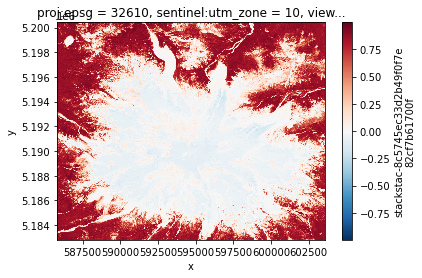

In [34]:
zzz.plot()

In [35]:
frames_ndvi_all = frames_ndvi_all.rio.reproject_match(frames)

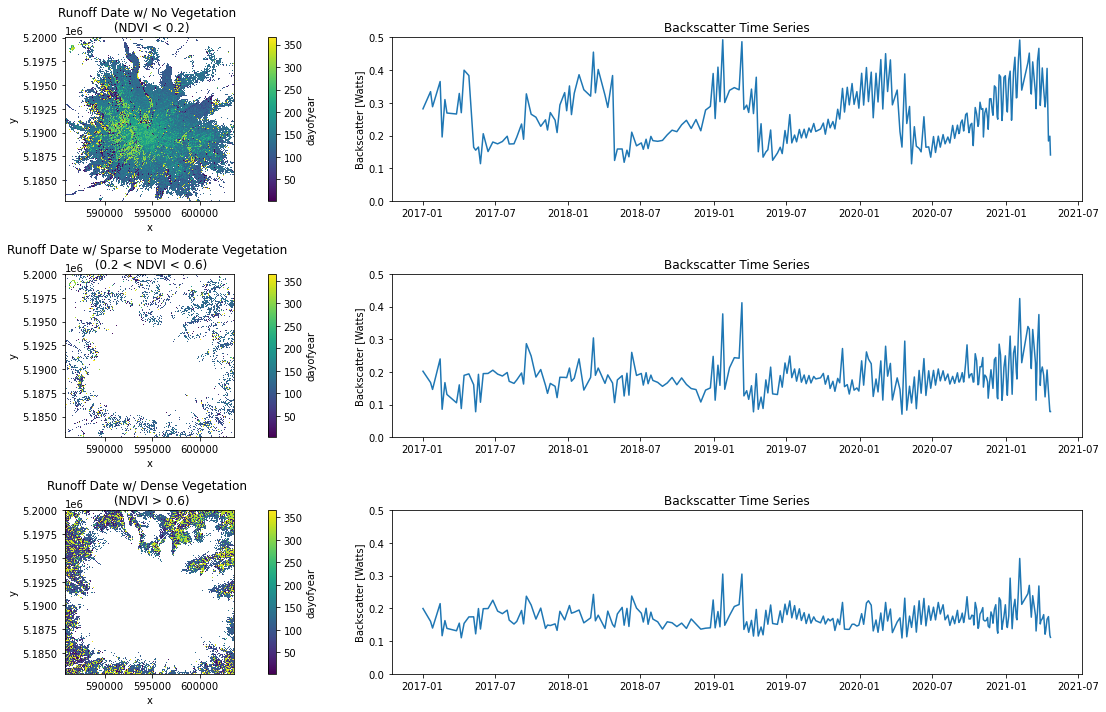

In [36]:
f,ax=plt.subplots(3,2,figsize=(20,10))
frames[mins_info].time.dt.dayofyear.where(frames_ndvi_all.values<0.2).plot(ax=ax[0,0])
ax[0,0].set_title('Runoff Date w/ No Vegetation \n (NDVI < 0.2)')
frames[mins_info].time.dt.dayofyear.where(frames_ndvi_all.values>0.2).where(frames_ndvi_all.values<0.6).plot(ax=ax[1,0])
ax[1,0].set_title('Runoff Date w/ Sparse to Moderate Vegetation \n (0.2 < NDVI < 0.6)')
#frames[mins_info].time.dt.dayofyear.where(frames_ndvi_all.values>0.4).where(frames_ndvi_all.values<0.6).plot(ax=ax[2,0])
#ax[2,0].set_title('Runoff Date w/ Moderate Vegetation \n (0.4 < NDVI < 0.6)')
frames[mins_info].time.dt.dayofyear.where(frames_ndvi_all.values>0.6).plot(ax=ax[2,0])
ax[2,0].set_title('Runoff Date w/ Dense Vegetation \n (NDVI > 0.6)')

ax[0,0].set_aspect('equal')
ax[1,0].set_aspect('equal')
ax[2,0].set_aspect('equal')


ax[0,1].plot(frames.where(frames_ndvi_all.values<0.2).time,frames.where(frames_ndvi_all.values<0.2).mean(dim=['x','y']))

ax[1,1].plot(frames.where(frames_ndvi_all.values>0.2).where(frames_ndvi_all.values<0.6).time,frames.where(frames_ndvi_all.values>0.2).where(frames_ndvi_all.values<0.6).mean(dim=['x','y']))

#ax[2,1].plot(frames.where(frames_ndvi_all.values>0.4).where(frames_ndvi_all.values<0.6).time,frames.where(frames_ndvi_all.values>0.4).where(frames_ndvi_all.values<0.6).mean(dim=['x','y']))

ax[2,1].plot(frames.where(frames_ndvi_all.values>0.6).time,frames.where(frames_ndvi_all.values>0.6).mean(dim=['x','y']))

ax[0,1].set_title('Backscatter Time Series')
ax[1,1].set_title('Backscatter Time Series')
ax[2,1].set_title('Backscatter Time Series')

ax[0,1].set_ylabel('Backscatter [Watts]')
ax[1,1].set_ylabel('Backscatter [Watts]')
ax[2,1].set_ylabel('Backscatter [Watts]')

ax[0,1].set_ylim([0,0.5])
ax[1,1].set_ylim([0,0.5])
ax[2,1].set_ylim([0,0.5])

plt.tight_layout()

In [37]:
# now plot time series means for all groups perhaps in a column to the right of each figure

/tmp/ipykernel_532347/1498834391.py:17: RuntimeWarning: Mean of empty slice
  backscatter_ts_for_bin = np.nanmean(frames_bin.data.reshape(frames_bin.shape[0],-1), axis=1) # (30,)


Text(0.5, 0.98, 'Mt. Rainier Sentinel-1 SAR Backscatter binned by Elevation \n (Runoff onset happens at the backscatter minimum / darkest pixels) \n each row: 2 week backscatter means for a given 100m elevation bin')

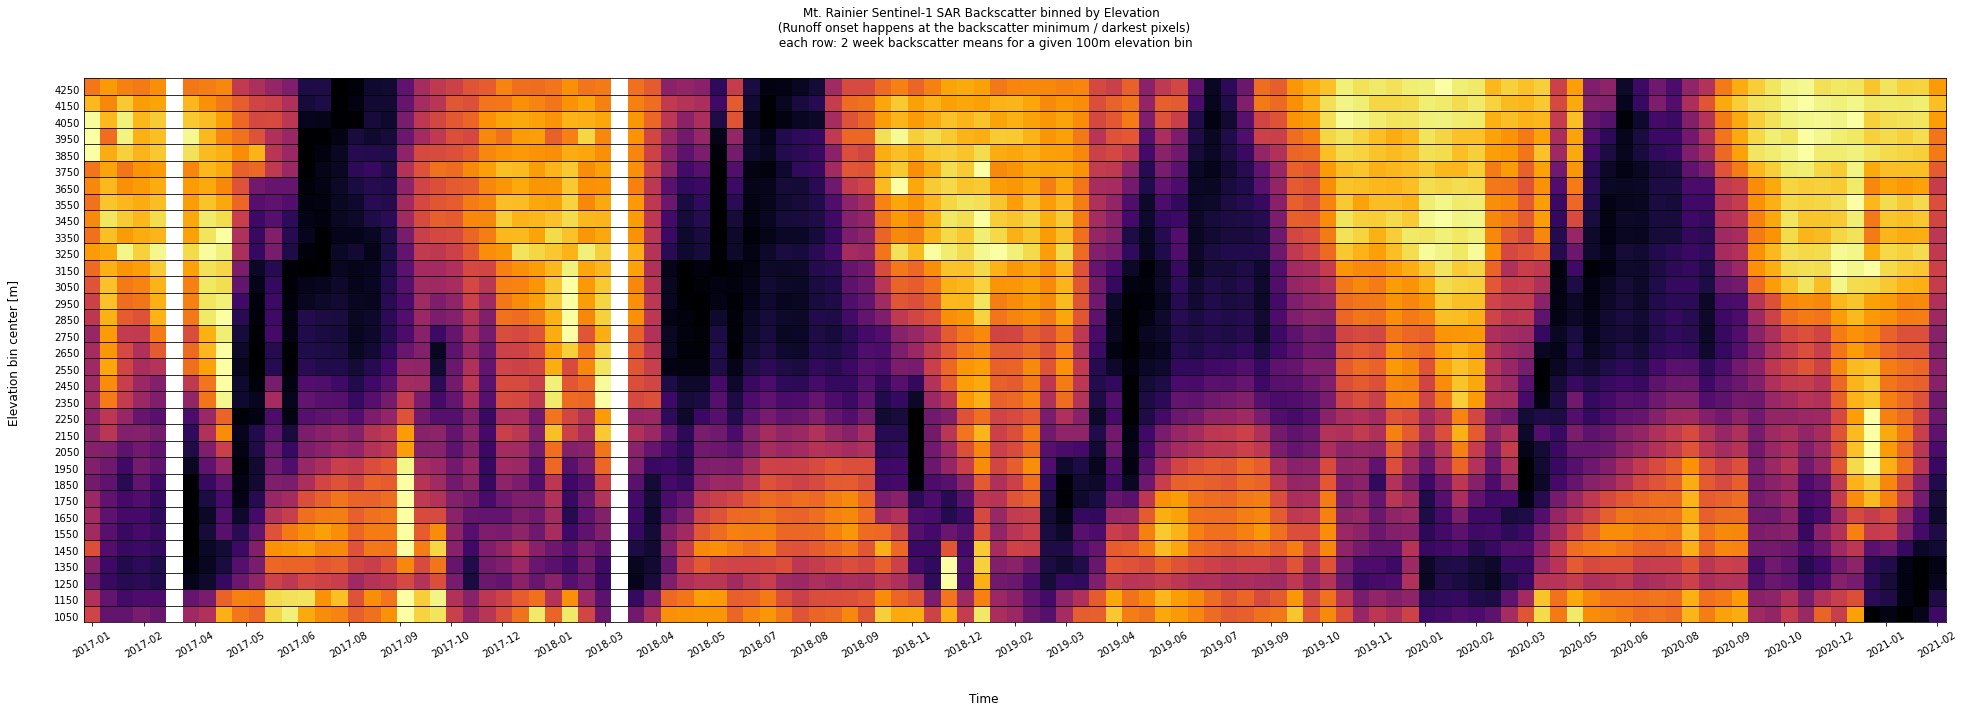

In [38]:
bin_size = 100
bin_centers = list(range(4250,1000,-100))

dem = rxr.open_rasterio('dem/dem_rainier_py3dep.tif',masked=True)
dem_projected = dem.rio.reproject_match(frames)
#dem_projected = dem_projected.rio.clip(rainier_glaciers.geometry,rainier_glaciers.crs,drop=False,invert=False) 

frames_elev = frames.where(frames_ndvi_all.values<0.2).resample(time='2W').mean(dim='time')
#month_labels = np.array(['J', 'F', 'M', 'A', 'M', 'J', 'J','A', 'S','O','N','D'])
#month_labels = np.array(['O','N','D','J', 'F', 'M', 'A', 'M', 'J', 'J','A', 'S'])

fig, ax = plt.subplots(len(bin_centers), figsize=(8*len(frames_elev)/26,10))
fig.subplots_adjust(hspace=0,wspace=0)

for idx,bin_center in enumerate(bin_centers):
    frames_bin = frames_elev.where(np.abs(dem_projected - bin_center) < bin_size//2)
    backscatter_ts_for_bin = np.nanmean(frames_bin.data.reshape(frames_bin.shape[0],-1), axis=1) # (30,)
    i = idx
    ax[i].imshow(backscatter_ts_for_bin.reshape(1,-1),cmap='inferno') #cool_r
    #ax[i].set_title(f"{bin_center-bin_size//2}-{bin_center+bin_size//2} m")
    ax[i].set_ylabel(f"{bin_center}",rotation='horizontal',loc='bottom',labelpad=30.0)
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    if i == 32:
        #ax[i].set_xticks(np.linspace(0,24,12), month_labels[0:12], rotation=0)
        #ax[i].set_xticks(np.linspace(0,24,12), rotation=0)
        datelabels=[pd.to_datetime(x).strftime('%Y-%m') for x in frames_elev.time.values[0::3]]
        del datelabels[-1]
        ax[i].set_xticks(np.linspace(0,len(frames_elev)-1,len(frames_elev)//3),datelabels, rotation=30)
        #ax[i].set_xlabel('Time')
fig.supxlabel("Time")
fig.supylabel("Elevation bin center [m]",x=0.11)
fig.suptitle("Mt. Rainier Sentinel-1 SAR Backscatter binned by Elevation \n (Runoff onset happens at the backscatter minimum / darkest pixels) \n each row: 2 week backscatter means for a given 100m elevation bin")

#plt.tight_layout()


In [39]:
int(dem.max())

4392

In [40]:
bin_size=100


In [41]:
list(range(int(math.ceil(dem.max()/100)*100)-bin_size//2,int(math.floor(dem.min()/100)*100),-bin_size))

[4350,
 4250,
 4150,
 4050,
 3950,
 3850,
 3750,
 3650,
 3550,
 3450,
 3350,
 3250,
 3150,
 3050,
 2950,
 2850,
 2750,
 2650,
 2550,
 2450,
 2350,
 2250,
 2150,
 2050,
 1950,
 1850,
 1750,
 1650,
 1550,
 1450,
 1350,
 1250,
 1150,
 1050,
 950,
 850]

In [42]:
# can try this instead https://matplotlib.org/stable/gallery/images_contours_and_fields/pcolormesh_levels.html#sphx-glr-gallery-images-contours-and-fields-pcolormesh-levels-py

In [43]:
def plot_timeseries_by_elevation_bin(ts_xr,dem_xr,bin_size=100,ax=None):
    dem_projected_xr = dem_xr.rio.reproject_match(ts_xr)
    dem_projected_xr=dem_projected_xr.where(ts_xr!=np.nan) # here mask DEM by ts_xr 
    
    bin_centers=list(range(int(math.floor(dem_projected_xr.max()/100)*100)-bin_size//2,int(math.ceil(dem_projected_xr.min()/100)*100),-bin_size))
    
    fig, ax = plt.subplots(len(bin_centers), figsize=(8*len(ts_xr)/26,10))
    fig.subplots_adjust(hspace=0,wspace=0)

    for i,bin_center in enumerate(bin_centers):
        ts_bin_xr = ts_xr.where(np.abs(dem_projected_xr - bin_center) < bin_size//2)
        backscatter_ts_for_bin = np.nanmean(ts_bin_xr.data.reshape(ts_bin_xr.shape[0],-1), axis=1) # (30,)
        ax[i].imshow(backscatter_ts_for_bin.reshape(1,-1),cmap='inferno',vmin=0,vmax=1) #cool_r
        ax[i].set_ylabel(f"{bin_center}",rotation='horizontal',loc='bottom',labelpad=30.0)
        ax[i].set_yticks([])
        ax[i].set_xticks([])
        if bin_center == bin_centers[-1]: #if last time in loop plot x label
            datelabels=[pd.to_datetime(x).strftime('%Y-%m') for x in ts_xr.time.values[0::3]]
            del datelabels[-1]
            ax[i].set_xticks(np.linspace(0,len(ts_xr)-1,len(ts_xr)//3),datelabels, rotation=30)
    fig.supxlabel("Time")
    fig.supylabel("Elevation bin center [m]",x=0.11)
    fig.suptitle("Mt. Rainier Sentinel-1 SAR Backscatter binned by Elevation \n (Runoff onset happens at the backscatter minimum / darkest pixels) \n each row: 2 week backscatter means for a given 100m elevation bin")

/tmp/ipykernel_532347/613704092.py:12: RuntimeWarning: Mean of empty slice
  backscatter_ts_for_bin = np.nanmean(ts_bin_xr.data.reshape(ts_bin_xr.shape[0],-1), axis=1) # (30,)
/tmp/ipykernel_532347/613704092.py:12: RuntimeWarning: Mean of empty slice
  backscatter_ts_for_bin = np.nanmean(ts_bin_xr.data.reshape(ts_bin_xr.shape[0],-1), axis=1) # (30,)
/tmp/ipykernel_532347/613704092.py:12: RuntimeWarning: Mean of empty slice
  backscatter_ts_for_bin = np.nanmean(ts_bin_xr.data.reshape(ts_bin_xr.shape[0],-1), axis=1) # (30,)
/tmp/ipykernel_532347/613704092.py:12: RuntimeWarning: Mean of empty slice
  backscatter_ts_for_bin = np.nanmean(ts_bin_xr.data.reshape(ts_bin_xr.shape[0],-1), axis=1) # (30,)
/tmp/ipykernel_532347/613704092.py:12: RuntimeWarning: Mean of empty slice
  backscatter_ts_for_bin = np.nanmean(ts_bin_xr.data.reshape(ts_bin_xr.shape[0],-1), axis=1) # (30,)
/tmp/ipykernel_532347/613704092.py:12: RuntimeWarning: Mean of empty slice
  backscatter_ts_for_bin = np.nanmean(ts_bin_

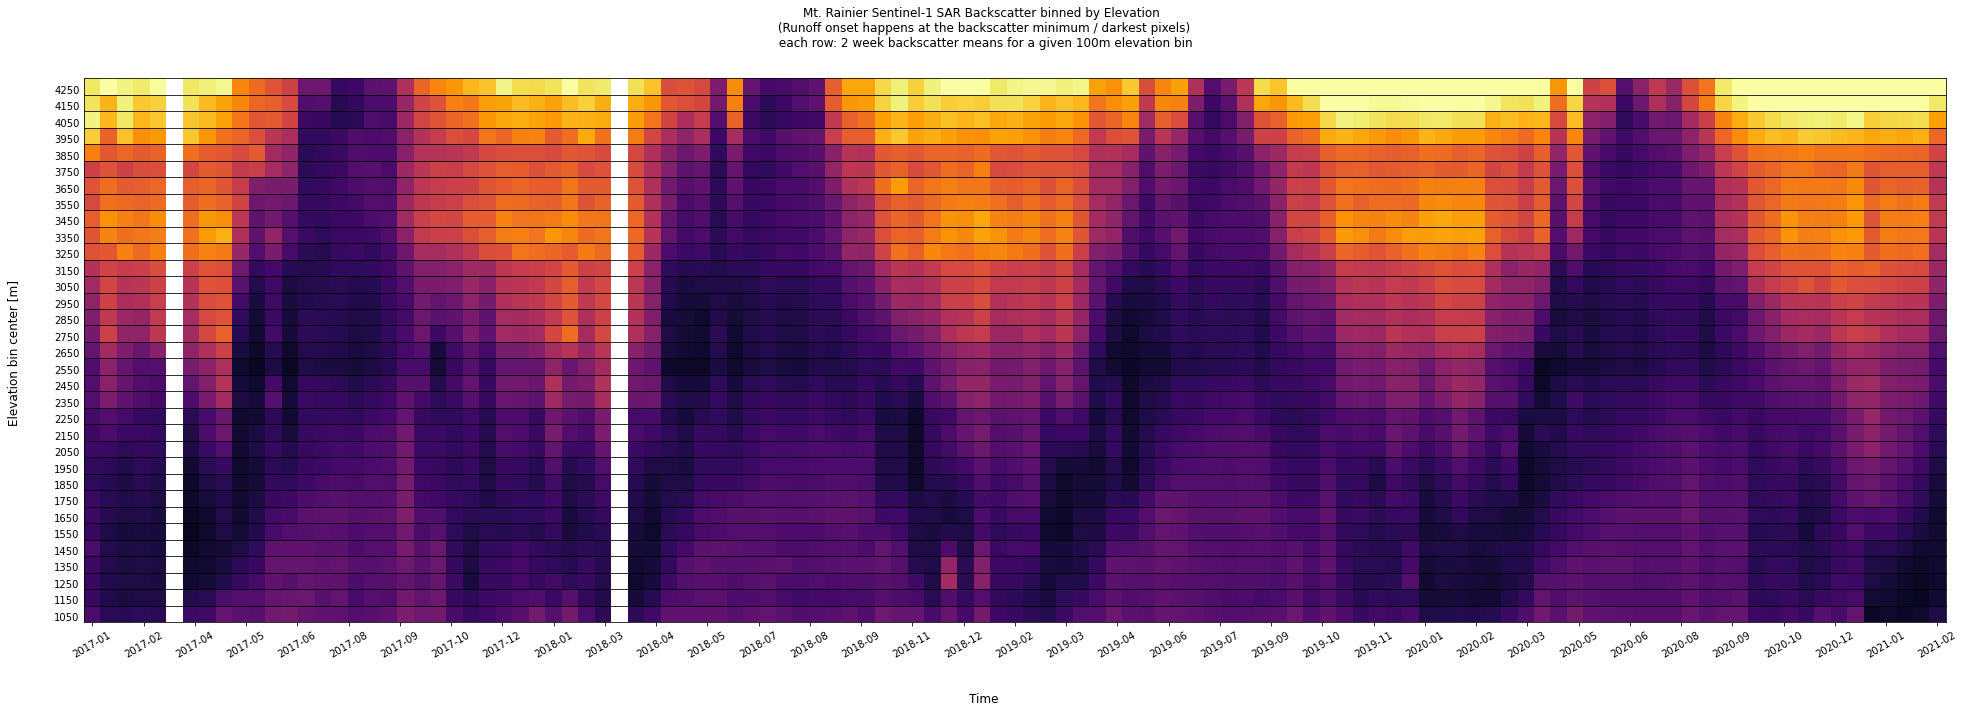

In [44]:
plot_timeseries_by_elevation_bin(frames_elev,dem,bin_size=100)

In [45]:
frames_elev

<xarray.DataArray 'stackstac-57e45068a5f86ce136d2cc50a7e61c31' (time: 113, y: 861, x: 889)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time                         (time) datetime64[ns] 2017-01-08 ... 2021-04-25
    band                         <U9 'gamma0_vv'
  * x                            (x) float64 5.858e+05 5.858e+05 ... 6.036e+05
  * y                            (y) float64 5.2e+06 5.2e+06 ... 5.183e+06
    sar:looks_equivalent_number  float64 4.3
    sar:resolution_range         float64 20.3
    proj:epsg                    int64 32610
    mgrs:grid_square             <U2 'ES'
    sar:frequency_band           <U1 'C'
    sentinel:mgrs                <U5 '10TES'
    sar:pixel_spacing_range      int64 10
    sar:looks_azimuth            int64 1
    sar:polarizations            object {'VV', 'VH'}
    mgrs:utm_zone                <U2 '10'
    sar:product_type             <U3 'RTC'
    sar:pixel_spacing_azimuth    int64 10
    sar:center_frequency         float64 5.405
    constellation                <U10 'sentinel-1'
    sar:looks_range              int64 5
    proj:shape                   object {5490}
    sar:instrument_mode          <U2 'IW'
    instruments                  <U5 'c-sar'
    proj:transform               object {0.0, 1.0, -20.0, 499980.0, 5200020.0...
    mgrs:latitude_band           <U1 'T'
    sar:observation_direction    <U5 'right'
    sar:resolution_azimuth       float64 22.6
    gsd                          int64 20
    title                        <U21 'Gamma0 VV backscatter'
    epsg                         int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(499980.0, 5090220.0, 609780.0...
    crs:         epsg:32610
    transform:   | 20.00, 0.00, 499980.00|\n| 0.00,-20.00, 5200020.00|\n| 0.0...
    resolution:  20.0

In [46]:
def plot_timeseries_by_elevation_bin(ts_ds,dem_ds,bin_size=100,ax=None,normalize_bins=False):
    if ax is None:
        ax = plt.gca()
    f = plt.gcf()
    
    dem_projected_ds = dem_ds.rio.reproject_match(ts_ds) # squeeze??
    dem_projected_ds = dem_projected_ds.where(ts_ds!=np.nan) # here mask DEM by ts_ds
    
    bin_centers=list(range(int(math.floor(dem_projected_ds.max()/100)*100)-bin_size//2,int(math.ceil(dem_projected_ds.min()/100)*100),-bin_size))
    backscatter_full = []

    for i,bin_center in enumerate(bin_centers):
        ts_bin_ds = ts_ds.where(np.abs(dem_projected_ds - bin_center) < bin_size//2)
        with warnings.catch_warnings(): #catches np.nanmean empty slices
            warnings.simplefilter("ignore", category=RuntimeWarning)
            backscatter_ts_for_bin = np.nanmean(ts_bin_ds.data.reshape(ts_bin_ds.shape[0],-1), axis=1) 
        backscatter_full.append(list(backscatter_ts_for_bin))
        
    backscatter_df = pd.DataFrame(backscatter_full,index=bin_centers,columns=ts_ds.time)
    
    if normalize_bins == True:
          backscatter_df = ((backscatter_df.T-backscatter_df.T.min())/(backscatter_df.T.max()-backscatter_df.T.min())).T
    
    colors = ax.pcolormesh(pd.to_datetime(ts_ds.time), bin_centers, backscatter_df,cmap='inferno',edgecolors=(1.0, 1.0, 1.0, 0.3)) #,vmin=0,vmax=0.5
    cbar = f.colorbar(colors,ax=ax)
    
    if normalize_bins == False:
        lab = 'Mean Backscatter [Watts]'
    else:
        lab = 'Normalized (Elevation-wise) Backscatter'
    
    cbar.ax.set_ylabel(lab, rotation=270, labelpad=15)

    ax.set_xlabel('Time')
    ax.set_ylabel('Elevation [m]')
    return(ax)

In [47]:
def plot_hyposometry(ts_ds,dem_ds,bin_size=100,ax=None):
    if ax is None:
        ax = plt.gca()
    f = plt.gcf()    
    dem_projected_ds = dem_ds.rio.reproject_match(ts_ds) # squeeze??
    dem_projected_ds = dem_projected_ds.where(ts_ds!=np.nan) # here mask DEM by ts_ds
    bin_edges=list(range(int(math.floor(dem_projected_ds.max()/100)*100)+bin_size,int(math.ceil(dem_projected_ds.min()/100)*100)-bin_size,-bin_size))
    ax.hist(dem_projected_ds.squeeze().isel(time=0).to_numpy().ravel(),bins=bin_edges[::-1],orientation='horizontal',histtype='bar',ec='k')
    ax.set_ylim([np.array(bin_edges).min(),np.array(bin_edges).max()])
    ax.set_xlabel('# of Pixels')
    ax.set_ylabel('Elevation [m]')
    ax.set_title('Hyposometry Plot')
    return(ax)

Text(0.5, 0.98, 'Mt. Rainier Sentinel-1 SAR Backscatter binned by Elevation \n (Runoff onset happens at the backscatter minimum / darkest pixels) \n each row: 2 week backscatter means for a given 100m elevation bin')

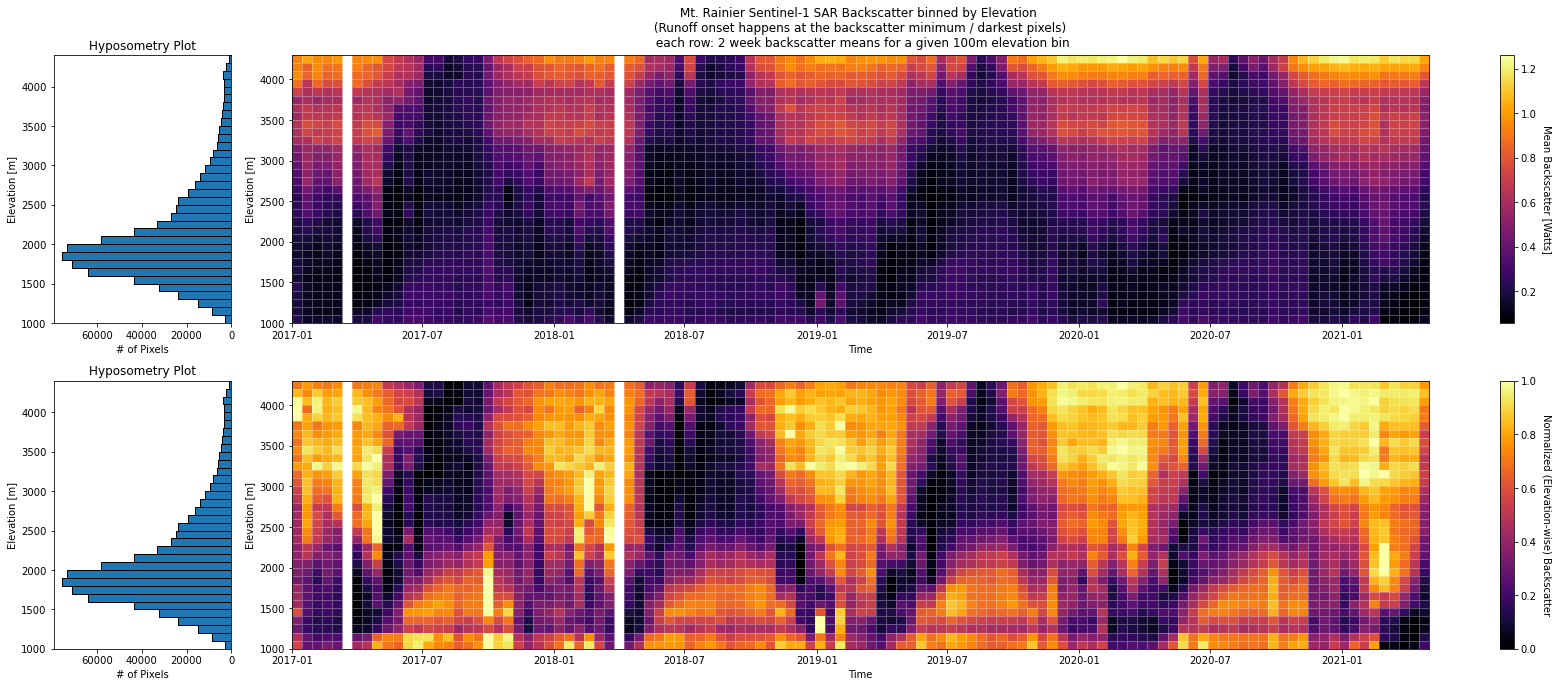

In [48]:
f,ax=plt.subplots(2,2,figsize=(24,10),gridspec_kw={'width_ratios': [1, 8]})
plot_timeseries_by_elevation_bin(frames_elev,dem,bin_size=100,ax=ax[0,1],normalize_bins=False)
plot_timeseries_by_elevation_bin(frames_elev,dem,bin_size=100,ax=ax[1,1],normalize_bins=True)
plot_hyposometry(frames_elev,dem,bin_size=100,ax=ax[0,0])
plot_hyposometry(frames_elev,dem,bin_size=100,ax=ax[1,0])
ax[0,0].invert_xaxis()
ax[1,0].invert_xaxis()
#plt.tight_layout()
f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.suptitle("Mt. Rainier Sentinel-1 SAR Backscatter binned by Elevation \n (Runoff onset happens at the backscatter minimum / darkest pixels) \n each row: 2 week backscatter means for a given 100m elevation bin")

<AxesSubplot:title={'center':'Hyposometry Plot'}, xlabel='# of Pixels', ylabel='Elevation [m]'>

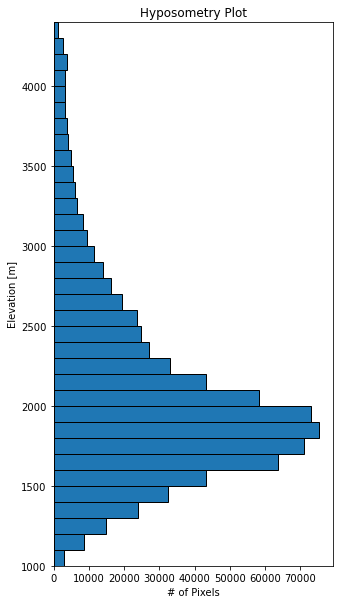

In [49]:
f,ax=plt.subplots(figsize=(5,10))
plot_hyposometry(frames_elev,dem,bin_size=100,ax=ax)

In [50]:
import s1_rtc_bs_utils

Text(0.5, 0.98, 'Mt. Rainier Sentinel-1 SAR Backscatter binned by Elevation \n (Runoff onset happens at the backscatter minimum / darkest pixels) \n each row: 2 week backscatter means for a given 100m elevation bin')

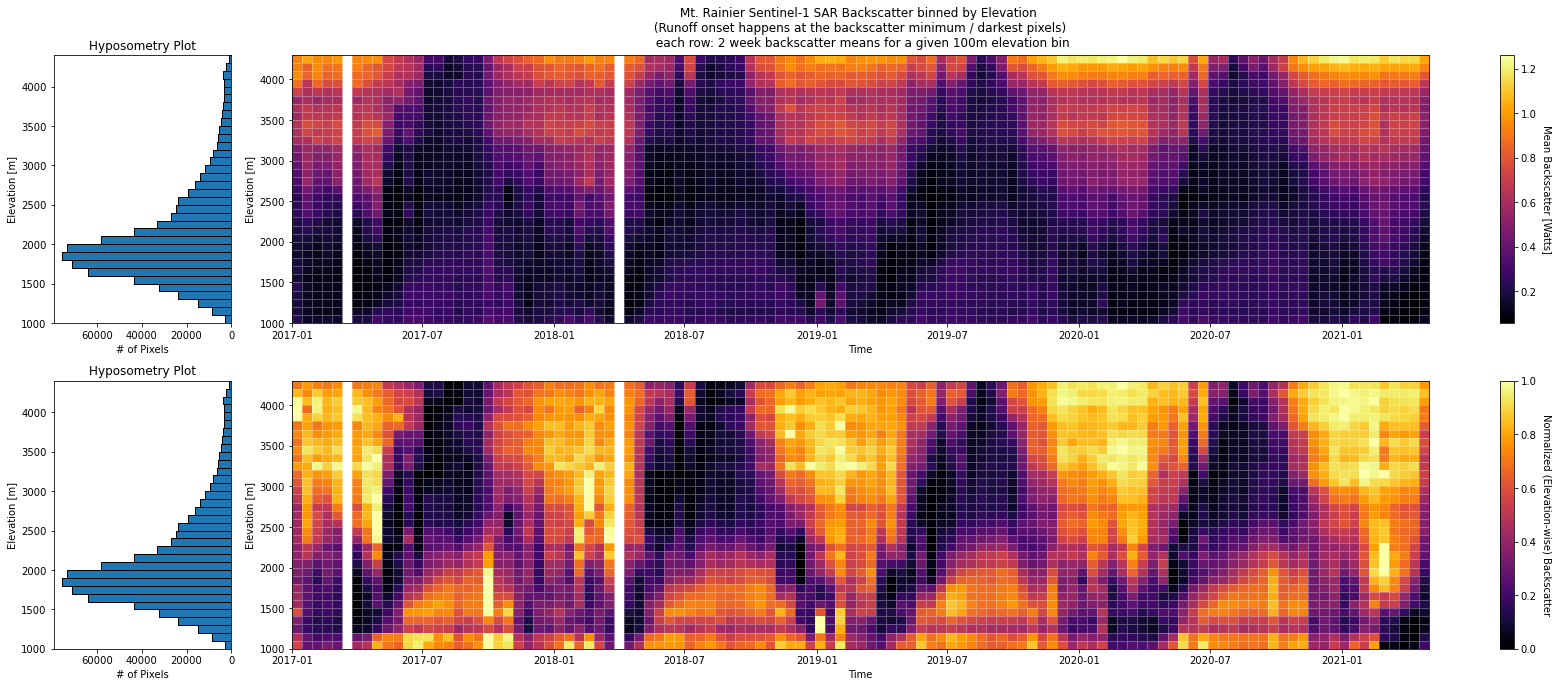

In [51]:
f,ax=plt.subplots(2,2,figsize=(24,10),gridspec_kw={'width_ratios': [1, 8]})
s1_rtc_bs_utils.plot_timeseries_by_elevation_bin(frames_elev,dem,bin_size=100,ax=ax[0,1],normalize_bins=False)
s1_rtc_bs_utils.plot_timeseries_by_elevation_bin(frames_elev,dem,bin_size=100,ax=ax[1,1],normalize_bins=True)
s1_rtc_bs_utils.plot_hyposometry(frames_elev,dem,bin_size=100,ax=ax[0,0])
s1_rtc_bs_utils.plot_hyposometry(frames_elev,dem,bin_size=100,ax=ax[1,0])
ax[0,0].invert_xaxis()
ax[1,0].invert_xaxis()
#plt.tight_layout()
f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.suptitle("Mt. Rainier Sentinel-1 SAR Backscatter binned by Elevation \n (Runoff onset happens at the backscatter minimum / darkest pixels) \n each row: 2 week backscatter means for a given 100m elevation bin")

In [52]:
# dot product of these two plots for some estimate of relative amount of loss?